# Guide
Now we predict using time end trip instead of time start trip in order to can 

Also try to estimate using ForecasterAutoreg but the result was not good.

show this predictions in real time from streamlit..

# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [1]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

# Imports

In [2]:
pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 25.6 MB/s 


In [3]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 29.9 MB/s 
     |████████████████████████████████| 6.3 MB 51.3 MB/s 
     |████████████████████████████████| 16.7 MB 83.9 MB/s 


In [4]:
#Pandas import
import pandas as pd
#Numpy import
import numpy as np
#Seaborn import
import seaborn as sns
#Geospatial imports
import matplotlib.pyplot as plt
import geopandas as gpd
#Import KMZ
import fiona
#Forecast time series
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
#Import for autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#Import for arima model
from statsmodels.tsa.arima_model import ARIMA
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


In [5]:
query = """
SELECT * FROM `vacio-276411.mainDataset.V1E_trips_grouped_all_hours_onlythree`
"""
df_tripsa_grouped = client.query(query).to_dataframe()

In [6]:
df_tripsa_grouped

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,2
1,1,2021-05-04 01:00:00+00:00,1
2,1,2021-05-04 02:00:00+00:00,2
3,1,2021-05-04 03:00:00+00:00,1
4,1,2021-05-04 04:00:00+00:00,1
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


In [7]:
df_tripsa_grouped.reset_index(drop=True)

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,2
1,1,2021-05-04 01:00:00+00:00,1
2,1,2021-05-04 02:00:00+00:00,2
3,1,2021-05-04 03:00:00+00:00,1
4,1,2021-05-04 04:00:00+00:00,1
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


#Timeseries

Create lag

In [8]:
#Shift method to create the lag variables
df_tripsa_grouped['trips_lag_28_days'] = df_tripsa_grouped['trips'].shift(28*24) #28 days before same hour
df_tripsa_grouped['trips_lag_14_days'] = df_tripsa_grouped['trips'].shift(14*24) #14 days before same hour
df_tripsa_grouped['trips_lag_7_days'] = df_tripsa_grouped['trips'].shift(7*24) #7 days before same hour
df_tripsa_grouped['trips_lag_1_days'] = df_tripsa_grouped['trips'].shift(1*24) # 1 day before same hour
df_tripsa_grouped['trips_lag_2_days'] = df_tripsa_grouped['trips'].shift(2*24) # 2 days before same hour
df_tripsa_grouped['trips_lag_1_hours'] = df_tripsa_grouped['trips'].shift(1) # 1 hour before
df_tripsa_grouped['trips_lag_2_hours'] = df_tripsa_grouped['trips'].shift(1) # 2 hours before
df_tripsa_grouped

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
0,1,2021-05-04 00:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-05-04 01:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,2.0,2.0
2,1,2021-05-04 02:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,1,2021-05-04 03:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,2.0,2.0
4,1,2021-05-04 04:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0,14.0,0.0,6.0,11.0,11.0,0.0,0.0
104756,9,2022-08-31 20:00:00+00:00,0,12.0,0.0,8.0,8.0,5.0,0.0,0.0
104757,9,2022-08-31 21:00:00+00:00,0,2.0,0.0,5.0,10.0,4.0,0.0,0.0
104758,9,2022-08-31 22:00:00+00:00,0,3.0,0.0,4.0,1.0,4.0,0.0,0.0


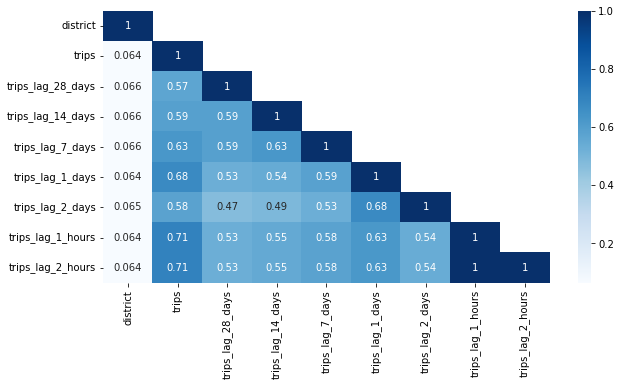

In [9]:
corr_matrix = df_tripsa_grouped.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="Blues")
plt.show()

Evaluation metric

In [10]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

Baseline

In [11]:
y_pred = df_tripsa_grouped['trips']
y_true = df_tripsa_grouped['trips_lag_1_hours']

In [12]:
result_1 = {'Method':['Baseline'],'MAPE':[mape(y_true, y_pred)],'WMAPE':[wmape(y_true, y_pred)]}
df_results = pd.DataFrame(result_1)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.716367,0.439382


Spit data

In [13]:
#Split data
#TODO: Without change this date in the future the test list will be bigger than now
#split_point = 40
#TODO: Remove august becouse is not ready
df_tripsa_grouped_original = df_tripsa_grouped.copy()
df_tripsa_grouped =  df_tripsa_grouped[df_tripsa_grouped['dateandtime'] < '2022-06-01']

split_point = '2022-05-01'
filter_train = df_tripsa_grouped['dateandtime'] < split_point
filter_valid = df_tripsa_grouped['dateandtime'] >= split_point

df_all_hours_data_train = df_tripsa_grouped[ filter_train].copy()
df_all_hours_data_valid = df_tripsa_grouped[ filter_valid ].copy()

Train model

In [14]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[features])
ytr = df_all_hours_data_train['trips']

mdl_SI = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl_SI.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

Evaluate model

In [15]:
Xval = imputer.transform(df_all_hours_data_valid[features])
yval = df_all_hours_data_valid['trips']

p = mdl_SI.predict(Xval)

In [16]:
p

array([4.08916667, 5.0095    , 3.43333333, ..., 6.6       , 4.583     ,
       3.23      ])

In [17]:
result_2 = {'Method':'RandomForest_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_2, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.716367,0.439382
1,RandomForest_1,0.505111,0.332118


Check district 4 and draw result

In [18]:
filter_district_df_all_hours_data_train = df_all_hours_data_train['district'] == 1
filter_district_df_all_hours_data_valid = df_all_hours_data_valid['district'] == 1
filter_district_df_tripsa_grouped = df_tripsa_grouped['district'] == 1

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl_SI.predict(Xval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


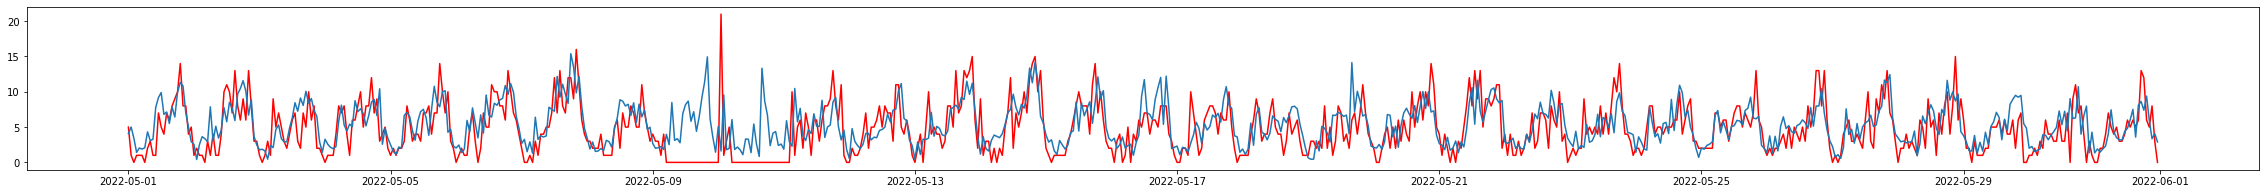

In [19]:
fig, ax = plt.subplots(figsize=(40, 3))

#Original
xpoints = df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['dateandtime']
yReal= df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['trips']

#Predicted
ypoints = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['dateandtime']
yEstimation = p

plt.plot(xpoints, yReal, c='red')
plt.plot(ypoints, yEstimation)
plt.show()

In [20]:
print('Mape for district 4' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 4 0.6757806641421034 WMAPE: 0.5025022351400473  Mean trips:  11.307646356033453  WMAPE percent: 0.044439153765356815


# Train a specific time series 
Train a specifict time series for this district to compare if the results could be better with a serie for every district instead of one for all

In [21]:
#Train model
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[filter_district_df_all_hours_data_train][features])
ytr = df_all_hours_data_train[filter_district_df_all_hours_data_train]['trips']

mdlRandomForest = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdlRandomForest.fit(Xtr, ytr)
#Evaluate model

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdlRandomForest.predict(Xval)
print('Mape for district 1' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 1 0.6463895825164978 WMAPE: 0.479822305848361  Mean trips:  11.307646356033453  WMAPE percent: 0.042433437582025266


In [22]:
#Calculate error
result_3 = {'Method':'RandomForest_1_DISC_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.716367,0.439382
1,RandomForest_1,0.505111,0.332118
2,RandomForest_1_DISC_1,0.646390,0.479822


# Test
Test manual para comprobar calidad de los datos

In [23]:
df_test = df_tripsa_grouped_original[ (df_tripsa_grouped_original['dateandtime'] > '2022-06-01') & (df_tripsa_grouped_original['dateandtime'] < '2022-06-30')  ]
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
9433,1,2022-06-01 01:00:00+00:00,1,1.0,1.0,2.0,0.0,1.0,0.0,0.0
9434,1,2022-06-01 02:00:00+00:00,1,1.0,1.0,2.0,2.0,2.0,1.0,1.0
9435,1,2022-06-01 03:00:00+00:00,3,1.0,4.0,2.0,2.0,1.0,1.0,1.0
9436,1,2022-06-01 04:00:00+00:00,4,4.0,6.0,2.0,4.0,3.0,3.0,3.0
9437,1,2022-06-01 05:00:00+00:00,5,8.0,9.0,7.0,7.0,2.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,7,12.0,10.0,10.0,14.0,9.0,16.0,16.0
103244,9,2022-06-29 20:00:00+00:00,10,11.0,9.0,12.0,12.0,8.0,7.0,7.0
103245,9,2022-06-29 21:00:00+00:00,7,5.0,12.0,12.0,14.0,9.0,10.0,10.0
103246,9,2022-06-29 22:00:00+00:00,13,10.0,7.0,10.0,8.0,5.0,7.0,7.0


In [24]:
Xval = imputer.transform(df_test[features])
yval = df_test['trips']

p = mdlRandomForest.predict(Xval)

In [25]:
df_test = df_test.assign(prediction = p)
df_test[['trips','prediction']]

,trips,prediction
9433,1,0.950
9434,1,2.305
9435,3,2.900
9436,4,3.185
9437,5,6.080
...,...,...
103243,7,12.550
103244,10,8.180
103245,7,8.820
103246,13,7.660


In [26]:
df_test['desviacion'] = abs(df_test['trips'] - df_test['prediction'])
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours,prediction,desviacion
9433,1,2022-06-01 01:00:00+00:00,1,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.950,0.050
9434,1,2022-06-01 02:00:00+00:00,1,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.305,1.305
9435,1,2022-06-01 03:00:00+00:00,3,1.0,4.0,2.0,2.0,1.0,1.0,1.0,2.900,0.100
9436,1,2022-06-01 04:00:00+00:00,4,4.0,6.0,2.0,4.0,3.0,3.0,3.0,3.185,0.815
9437,1,2022-06-01 05:00:00+00:00,5,8.0,9.0,7.0,7.0,2.0,4.0,4.0,6.080,1.080
...,...,...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,7,12.0,10.0,10.0,14.0,9.0,16.0,16.0,12.550,5.550
103244,9,2022-06-29 20:00:00+00:00,10,11.0,9.0,12.0,12.0,8.0,7.0,7.0,8.180,1.820
103245,9,2022-06-29 21:00:00+00:00,7,5.0,12.0,12.0,14.0,9.0,10.0,10.0,8.820,1.820
103246,9,2022-06-29 22:00:00+00:00,13,10.0,7.0,10.0,8.0,5.0,7.0,7.0,7.660,5.340


In [27]:
df_test_error = df_test.groupby('trips')['desviacion'].mean().reset_index()
df_test_error

,trips,desviacion
0,0,3.447726
1,1,2.459650
2,2,2.270021
3,3,2.421341
4,4,2.428668
...,...,...
58,60,34.250000
59,61,35.360000
60,62,36.685000
61,64,38.460000


In [28]:
df_test_error['fallo'] = df_test_error['desviacion'] / df_test_error['trips']
df_test_error

,trips,desviacion,fallo
0,0,3.447726,inf
1,1,2.459650,2.459650
2,2,2.270021,1.135010
3,3,2.421341,0.807114
4,4,2.428668,0.607167
...,...,...,...
58,60,34.250000,0.570833
59,61,35.360000,0.579672
60,62,36.685000,0.591694
61,64,38.460000,0.600938


In [29]:
#Marco como aceptable un desajuste de viajes en un 15%
df_test_error['aceptable'] = df_test_error['fallo'] < 0.15
df_test_error

,trips,desviacion,fallo,aceptable
0,0,3.447726,inf,False
1,1,2.459650,2.459650,False
2,2,2.270021,1.135010,False
3,3,2.421341,0.807114,False
4,4,2.428668,0.607167,False
...,...,...,...,...
58,60,34.250000,0.570833,False
59,61,35.360000,0.579672,False
60,62,36.685000,0.591694,False
61,64,38.460000,0.600938,False


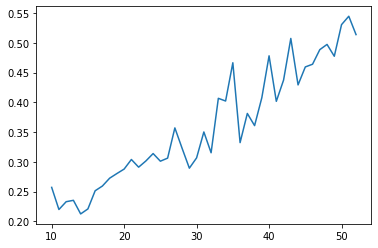

In [30]:
#import matplotlib.pyplot as plt
#import numpy as np

xpoints = np.array([1, 2, 6, 8])
ypoints = np.array([3, 8, 1, 10])

#Remove first and las 10 to not lose the data size of the plot
plt.plot(df_test_error['trips'][10:-10], df_test_error['fallo'][10:-10] )
plt.show()

In [31]:
df_tmp= df_test.groupby('trips').size().reset_index()
df_tmp

,trips,0
0,0,189
1,1,250
2,2,316
3,3,406
4,4,372
...,...,...
58,60,2
59,61,1
60,62,2
61,64,2


In [32]:
df_tmp[0]

0     189
1     250
2     316
3     406
4     372
     ... 
58      2
59      1
60      2
61      2
62      1
Name: 0, Length: 63, dtype: int64

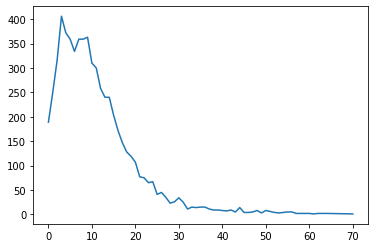

In [33]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = df_tmp['trips']
ypoints = df_tmp[0]

plt.plot(xpoints, ypoints)
plt.show()

In [34]:
df_tmp[0][40:]

40     8
41     7
42     9
43     5
44    14
45     4
46     4
47     5
48     8
49     3
50     8
51     6
52     4
53     3
54     4
55     5
56     5
57     2
58     2
59     1
60     2
61     2
62     1
Name: 0, dtype: int64

# Now try without last 24hours data

In [35]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[features])
ytr = df_all_hours_data_train['trips']

mdlRandomForest_no24 = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdlRandomForest_no24.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

In [36]:
Xval = imputer.transform(df_all_hours_data_valid[features])
yval = df_all_hours_data_valid['trips']

p = mdlRandomForest_no24.predict(Xval)

In [37]:
#Calculate error
result_3 = {'Method':'RandomForest_NO_YESTERDAY','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.716367,0.439382
1,RandomForest_1,0.505111,0.332118
2,RandomForest_1_DISC_1,0.646390,0.479822
3,RandomForest_NO_YESTERDAY,0.544799,0.378053


# Export model

In [38]:
import joblib
joblib.dump(mdl_SI, 'model_SI.pkl', compress=9)

['model_SI.pkl']

# Try skforecast
More info: https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html

In [39]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0


In [40]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [41]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']
objective = ['trips']

In [42]:
#Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=df_all_hours_data_train['trips'])
forecaster

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:257: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:257: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 78191] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-31 15:26:25 
Last fit date: 2022-08-31 15:26:54 
Skforecast version: 0.4.3 

In [43]:
# Predicciones
# ==============================================================================
steps = 100
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

78192    4.48
78193    3.96
78194    3.31
78195    4.07
78196    4.39
Name: pred, dtype: float64

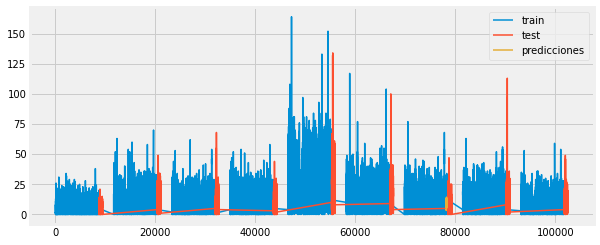

In [44]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_all_hours_data_train['trips'].plot(ax=ax, label='train')
df_all_hours_data_valid['trips'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();